In [ ]:
#Uso de librerías. Celda nº1
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings
from collections import defaultdict
from tabulate import tabulate
from google.colab import data_table
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Cargar el archivo Excel
xls = pd.ExcelFile("Test_animales.xlsx")
# Leer las hojas y asignar la nueva variable "degenera"
df_list = []
for i, sheet in enumerate(xls.sheet_names):
    df = xls.parse(sheet)
    df["degenera"] = i  # Asigna 0 a la primera hoja, 1 a la segunda, etc.
    df_list.append(df)

# Unir todas las hojas en un solo DataFrame
df = pd.concat(df_list, ignore_index=True)
# Guardar el resultado en un CSV
df.to_csv("Test_animales.csv", index=False)


data = pd.read_csv("Test_animales.csv", header =2)
# Asignar la primera fila como nombres de columnas
data.columns = data.iloc[0]  # Toma la primera fila como encabezados
data = data[1:].reset_index(drop=True)  # Eliminar la fila duplicada y resetear índice

# Asegurar que no hay nombres de columna repetidos
data.columns = [str(col) for col in data.columns]
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI,OD,OI,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD (400 um),OI,0
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1,WT-110,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,WT-111,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,WT-112,♀,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1,WT-113,♂,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,P11,R10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
255,P11,R11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
256,P11,R12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
257,P11,R13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [ ]:
# Contador para cada nombre de columna duplicada
oi_counter = 1
od_counter = 1
new_columns = []

# Renombrar correctamente las columnas duplicadas de OI y OD
for col in data.columns:
    if col.startswith("OI"):
        new_columns.append(f"OI_{oi_counter}")
        oi_counter += 1
    elif col.startswith("OD"):
        new_columns.append(f"OD_{od_counter}")
        od_counter += 1
    elif col.startswith("0"):
        new_columns.append("degenera")
    else:
        new_columns.append(col) # Mantener los demás nombres iguales
# Aplicar los nuevos nombres
data.columns = new_columns
# Mostrar el resultado
print(data.columns)


Index(['Edad sacrificio', 'ID animal', 'Sexo', 'P30', '3m', '4m', '6m', '9m',
       '12m', '17-21m', 'OD_1', 'OI_1', 'OD_2', 'OI_2', 'OD_3', 'OI_3', 'OD_4',
       'OI_4', 'F.Optomotor', 'Edad Opto', 'Dato OPT', 'F.OCT', 'OD_5', 'OI_5',
       'degenera'],
      dtype='object')


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
0    131
1    128
Name: count, dtype: int64


In [ ]:
# Contar valores NaN en cada columna
nan_counts = data.isna().sum()
print(tabulate(nan_counts.reset_index(), headers=["Variable", "Cantidad de NaN"], tablefmt="pretty"))

+----+-----------------+-----------------+
|    |    Variable     | Cantidad de NaN |
+----+-----------------+-----------------+
| 0  | Edad sacrificio |        4        |
| 1  |    ID animal    |        1        |
| 2  |      Sexo       |       15        |
| 3  |       P30       |       246       |
| 4  |       3m        |       236       |
| 5  |       4m        |       252       |
| 6  |       6m        |       243       |
| 7  |       9m        |       243       |
| 8  |       12m       |       239       |
| 9  |     17-21m      |       241       |
| 10 |      OD_1       |       180       |
| 11 |      OI_1       |       184       |
| 12 |      OD_2       |       181       |
| 13 |      OI_2       |       184       |
| 14 |      OD_3       |       180       |
| 15 |      OI_3       |       184       |
| 16 |      OD_4       |       181       |
| 17 |      OI_4       |       184       |
| 18 |   F.Optomotor   |       160       |
| 19 |    Edad Opto    |       154       |
| 20 |    D

In [ ]:
# Seleccionar columnas que empiezan con "OI", "OD" o "Dato OPT"
oi_od_columns = [col for col in data.columns if col.startswith("OI") or col.startswith("OD") or col.startswith("Dato OPT")]
# Eliminar filas donde TODAS esas columnas sean NaN (si al menos una tiene valor, la fila se queda)
data = data.dropna(subset=oi_od_columns, how="all").reset_index(drop=True)
display(data)

,Edad sacrificio,ID animal,Sexo,P30,3m,4m,6m,9m,12m,17-21m,...,OI_3,OD_4,OI_4,F.Optomotor,Edad Opto,Dato OPT,F.OCT,OD_5,OI_5,degenera
0,1,WT-25,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,...,19.5,146.7,166.1,2020-02-17 00:00:00,"1,3m",0.572,2020-02-17 00:00:00,52.818,202.818,0
1,1.3,WT-23,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,...,19.9,123.1,135.2,2020-02-17 00:00:00,"1,3m",0.574,2020-02-17 00:00:00,47.365,202.364,0
2,1.3,WT-24,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,...,19.3,184.3,183.7,2020-02-17 00:00:00,"1,3m",0.594,2020-02-17 00:00:00,54.94,209.455,0
3,1.3,WT-26,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,131.8,166.9,2020-02-17 00:00:00,"1,3m",0.550,2020-02-17 00:00:00,57.273,212.909,0
4,1.3,WT-27,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,...,16.5,181.2,142.6,2020-02-17 00:00:00,"1,3m",0.616,2020-02-17 00:00:00,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,19,12120,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,...,3,52,"84,8",NaN,NaN,"0,308",2021-04-28 00:00:00,NaN,NaN,1
103,20,12004,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,...,"3,2","63,1","57,1",NaN,NaN,"0,297",2021-04-26 00:00:00,NaN,NaN,1
104,20,12045,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,...,4,"93,2",85,NaN,NaN,"0,319",2021-04-27 00:00:00,NaN,NaN,1
105,20,12046,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,...,7,"52,5","91,7",NaN,NaN,"0,308",2021-04-27 00:00:00,NaN,NaN,1


In [ ]:
data.drop('Edad sacrificio',axis =1, inplace =True)
data.drop('F.Optomotor',axis =1, inplace =True)
data.drop('F.OCT',axis =1, inplace =True)
data.drop('ID animal',axis =1, inplace =True)
display(data)

,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,♀,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,♀,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,♀,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,♂,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,♂,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,♀,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,♀,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,♂,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Sexo"] = data["Sexo"].map({"♀": 0, "♂": 1})
data["Sexo"] = data["Sexo"].fillna(-1).astype(int)
print(data["Sexo"].value_counts())
display(data)

Sexo
 1    56
 0    44
-1     7
Name: count, dtype: int64


,Sexo,P30,3m,4m,6m,9m,12m,17-21m,OD_1,OI_1,...,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera
0,0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,224.1,262.1,...,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0
1,0,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,147.6,217.6,...,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0
2,0,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,318.8,291.6,...,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0
3,1,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,206.7,197.6,...,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0
4,1,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,292.1,198.6,...,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,"78,1","72,1",...,"181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1
103,0,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,"65,1","60,8",...,"188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1
104,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,"92,2","83,8",...,"246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1
105,1,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,79,"113,1",...,"249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1


In [ ]:
data["Edad_ERG"] = np.nan
edad_map = {
    "P30": 1,
    "3m": 3,
    "4m": 4,
    "6m": 6,
    "9m": 9,
    "12m": 12,
    "17-21m": 19
}

for col, val in edad_map.items():
    data.loc[data[col].notna(), "Edad_ERG"] = val

# Normalizar con Min-Max Scaling
min_val = min(edad_map.values())  # Mínimo (1)
max_val = max(edad_map.values())  # Máximo (19)
data["Edad_ERG"] = (data["Edad_ERG"] - min_val) / (max_val - min_val)
# Crear diccionario con valores normalizados
edad_normalizada = {
    nombre: round((valor - min_val) / (max_val - min_val), 3)
    for nombre, valor in edad_map.items()
}

# Mostrar
for nombre, valor_norm in edad_normalizada.items():
    print(f"{nombre}: {valor_norm}")

display(data[["P30", "3m", "4m", "6m", "9m", "12m", "17-21m", "Edad_ERG"]])

P30: 0.0
3m: 0.111
4m: 0.167
6m: 0.278
9m: 0.444
12m: 0.611
17-21m: 1.0


,P30,3m,4m,6m,9m,12m,17-21m,Edad_ERG
0,110220-5,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,110220-3,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,110220-4,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,110220-1,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,110220-2,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...
102,NaN,NaN,NaN,NaN,NaN,NaN,110521-5,1.0
103,NaN,NaN,NaN,NaN,NaN,NaN,190521-2,1.0
104,NaN,NaN,NaN,NaN,NaN,NaN,190521-7,1.0
105,NaN,NaN,NaN,NaN,NaN,NaN,190521-6,1.0


In [ ]:
data = data.drop(columns=["P30", "3m", "4m", "6m", "9m", "12m", "17-21m"])
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop_duplicates()
data = data.reset_index(drop=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
103,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
104,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
105,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
data = data.drop(index=[47,48, 49])
data = data.reset_index(drop=True)
data = data.replace({'\*': ''}, regex=True)
display(data)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,Edad Opto,Dato OPT,OD_5,OI_5,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,"1,3m",0.572,52.818,202.818,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,"1,3m",0.574,47.365,202.364,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,"1,3m",0.594,54.94,209.455,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,"1,3m",0.550,57.273,212.909,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,"1,3m",0.616,51.091,202.545,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",NaN,"0,308",NaN,NaN,1,1.0
100,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",NaN,"0,297",NaN,NaN,1,1.0
101,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,NaN,"0,319",NaN,NaN,1,1.0
102,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",NaN,"0,308",NaN,NaN,1,1.0


In [ ]:
# Contar las instancias de cada valor en "degenera"
conteo = data["degenera"].value_counts()
print(conteo)

degenera
1    57
0    47
Name: count, dtype: int64


In [ ]:
# Crear el segundo conjunto de datos eliminando variables innecesarias
data_modelo2 = data.drop(columns=["Edad Opto", "Dato OPT", "OD_5", "OI_5"])
display(data_modelo2)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99,0,"78,1","72,1","174,8","181,2",2,3,52,"84,8",1,1.0
100,0,"65,1","60,8","199,9","188,7",5,"3,2","63,1","57,1",1,1.0
101,1,"92,2","83,8","264,3","246,8",3,4,"93,2",85,1,1.0
102,1,79,"113,1","191,6","249,4",5,7,"52,5","91,7",1,1.0


In [ ]:
import numpy as np

# Lista de columnas a verificar
columnas_verificar = ["OD_1", "OI_1", "OD_2", "OI_2", "OD_3", "OI_3", "OD_4", "OI_4"]
data_modelo2.replace({',': '.'}, regex=True, inplace=True)
# Reemplazar "-" y "?" por NaN
data_modelo2.replace({"-": np.nan, "?": np.nan}, inplace=True)
# Eliminar filas donde TODAS estas columnas sean NaN
data_modelo2 = data_modelo2.dropna(subset=columnas_verificar, how='all')
data_modelo2.reset_index(drop=True, inplace=True)
display(data_modelo2)

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0,0.0
1,0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0,0.0
2,0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0,0.0
3,1,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0,0.0
4,1,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69,0,78.1,72.1,174.8,181.2,2,3,52,84.8,1,1.0
70,0,65.1,60.8,199.9,188.7,5,3.2,63.1,57.1,1,1.0
71,1,92.2,83.8,264.3,246.8,3,4,93.2,85,1,1.0
72,1,79,113.1,191.6,249.4,5,7,52.5,91.7,1,1.0


In [ ]:
# Reemplazar valores no numéricos y convertir a int
#data_modelo2 = data_modelo2.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
data_modelo2 = data_modelo2.apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)
# Verificar que todo es int
print(data_modelo2.dtypes)

Sexo        float64
OD_1        float64
OI_1        float64
OD_2        float64
OI_2        float64
OD_3        float64
OI_3        float64
OD_4        float64
OI_4        float64
degenera    float64
Edad_ERG    float64
dtype: object


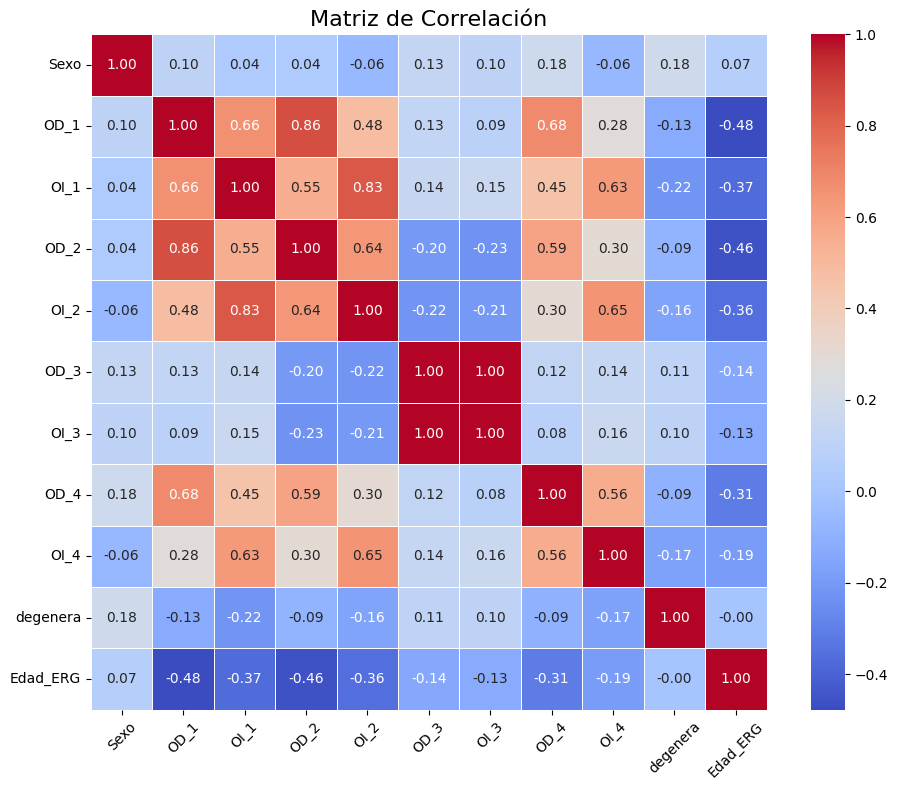

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tu DataFrame se llama data_modelo2
# Si no lo has cargado aún: data_modelo2 = pd.read_csv('tu_archivo.csv')

# Calcular matriz de correlación
correlation_matrix = data_modelo2.corr(numeric_only=True)

# Mostrar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Matriz de Correlación", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Importar librerías necesarias
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE (solo para problemas de clasificación desbalanceada)
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)

# Mostrar ejemplos de datos aumentados
print("Datos aumentados con ruido:")
print(X_train_augmented_noise[:5])

print("Datos aumentados con escalado:")
print(X_train_augmented_scaled[:5])

print("Datos aumentados con SMOTE:")
print(X_train_augmented_smote[:5])

print("Datos aumentados con Bootstrap:")
print(X_train_augmented_bootstrap[:5])

# Aquí es donde usarías los datos aumentados en el entrenamiento de tu modelo, por ejemplo:
# Si eliges usar SMOTE:
# X_train_augmented = X_train_augmented_smote
# y_train_augmented = y_train_augmented_smote

# Si eliges usar ruido o escalado, puedes combinar los métodos de la siguiente manera:
# X_train_augmented = X_train_augmented_noise  # O cualquier otro método
# y_train_augmented = y_train  # Etiquetas originales


display (data_modelo2)

Datos aumentados con ruido:
[[ 0.61513455  1.25113391  1.01761179  0.69756279  0.51790465 -0.00321537
  -0.0094977   1.41864823  1.10364679  0.58673761]
 [ 0.85383062 -0.19041717  0.39923024  0.00648541 -0.01285114 -0.16366548
  -0.1546573   0.66254036  0.72068281  0.17145264]
 [ 0.77357597  0.22475416  0.3467325  -1.93691174 -1.81214943  0.22750374
   0.07103551  0.72810508 -2.05415127 -0.82757062]
 [ 0.83950279 -1.72991122 -1.29220807 -0.76656468 -0.43907972 -0.35147847
  -0.38761788 -1.95555675 -2.00432822 -0.19318578]
 [-1.14164797  0.23026479  0.31888952  0.61003592  0.4974381  -0.00605
  -0.10536189 -0.04659466  0.7351437  -0.99860345]]
Datos aumentados con escalado:
[[ 0.88410439  1.22262081  1.0311148   0.80267717  0.41056701  0.00369106
  -0.04396519  1.53256965  1.41679701  0.65697747]
 [ 0.88410439 -0.20390226  0.30108552  0.07136385  0.20729558 -0.07647799
  -0.10395589  0.68153089  0.74106865  0.19369057]
 [ 0.88410439  0.22372058  0.354621   -2.13134364 -2.17191656  0.107

,Sexo,OD_1,OI_1,OD_2,OI_2,OD_3,OI_3,OD_4,OI_4,degenera,Edad_ERG
0,0.0,224.1,262.1,540.4,628.0,16.8,19.5,146.7,166.1,0.0,0.0
1,0.0,147.6,217.6,320.6,501.6,21.6,19.9,123.1,135.2,0.0,0.0
2,0.0,318.8,291.6,719.6,630.5,14.2,19.3,184.3,183.7,0.0,0.0
3,1.0,206.7,197.6,527.3,492.3,14.3,18.0,131.8,166.9,0.0,0.0
4,1.0,292.1,198.6,696.6,470.4,17.5,16.5,181.2,142.6,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
69,0.0,78.1,72.1,174.8,181.2,2.0,3.0,52.0,84.8,1.0,1.0
70,0.0,65.1,60.8,199.9,188.7,5.0,3.2,63.1,57.1,1.0,1.0
71,1.0,92.2,83.8,264.3,246.8,3.0,4.0,93.2,85.0,1.0,1.0
72,1.0,79.0,113.1,191.6,249.4,5.0,7.0,52.5,91.7,1.0,1.0


Modelo: Random Forest
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.33      0.40      0.36         5

    accuracy                           0.53        15
   macro avg       0.50      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15

Matriz de Confusión para Random Forest:
 [[6 4]
 [3 2]]


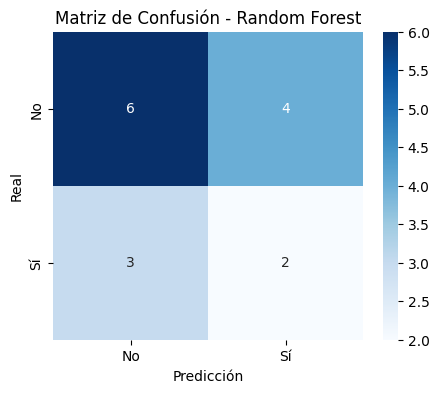

In [ ]:
# Importar librerías necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluación de Random Forest
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Modelo: Random Forest")
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_rf)}")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"Matriz de Confusión para Random Forest:\n", cm_rf)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 0.9661
🔹 Accuracy en test: 0.5333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.64      0.70      0.67        10
         1.0       0.25      0.20      0.22         5

    accuracy                           0.53        15
   macro avg       0.44      0.45      0.44        15
weighted avg       0.51      0.53      0.52        15



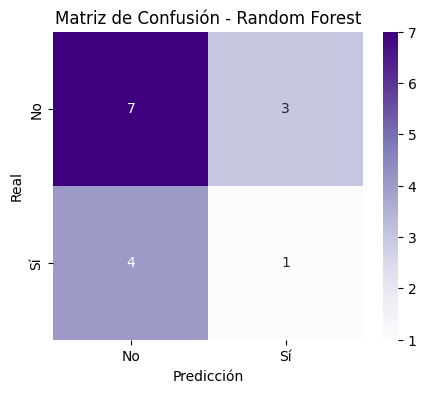

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 0.9831
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



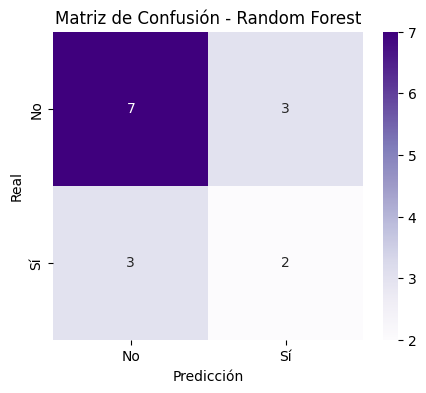

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 0.9531
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



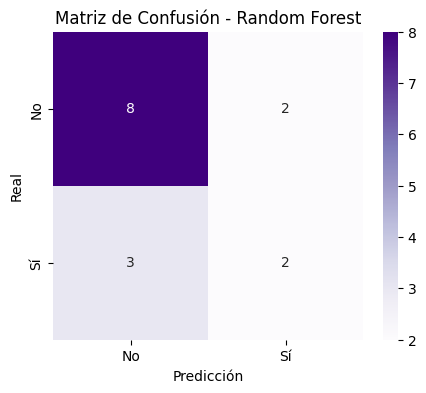

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 0.9831
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        10
         1.0       0.50      0.60      0.55         5

    accuracy                           0.67        15
   macro avg       0.64      0.65      0.64        15
weighted avg       0.69      0.67      0.67        15



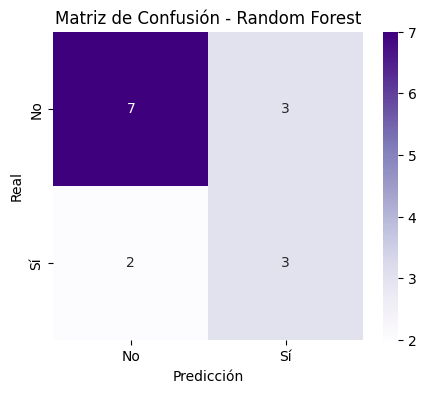

In [ ]:
# Importar librerías necesarias
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Crear el modelo RandomForest con los hiperparámetros dados
    rf = RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

    # Entrenar el modelo
    rf.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Purples", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Random Forest")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


Modelo: SVM
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.33      0.40      0.36         5

    accuracy                           0.53        15
   macro avg       0.50      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15

Matriz de Confusión para SVM:
 [[6 4]
 [3 2]]


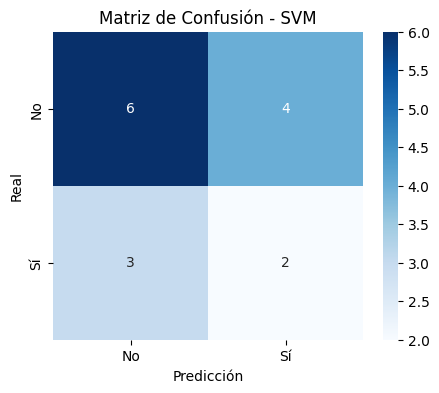

In [ ]:
# Importar librerías necesarias
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Escalar las características para el modelo SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

# Evaluación de SVM
y_pred_svm = svm.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Modelo: SVM")
print(f"Accuracy: {accuracy_svm:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_svm)}")
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Matriz de Confusión para SVM:\n", cm_svm)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - SVM")
plt.show()


Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



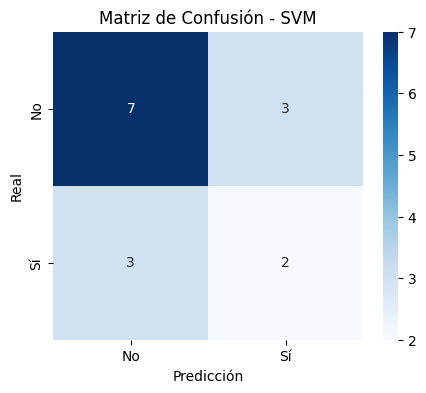

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



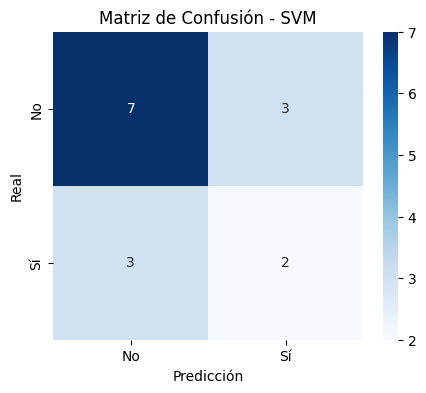

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 0.8281
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



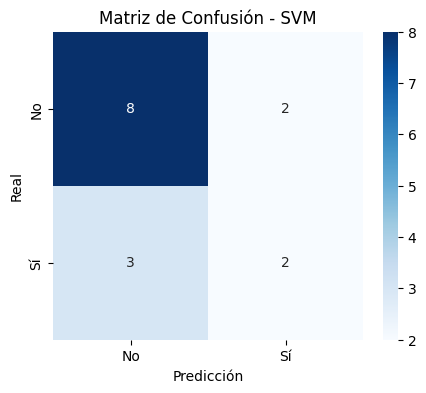

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.7333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        10
         1.0       0.67      0.40      0.50         5

    accuracy                           0.73        15
   macro avg       0.71      0.65      0.66        15
weighted avg       0.72      0.73      0.71        15



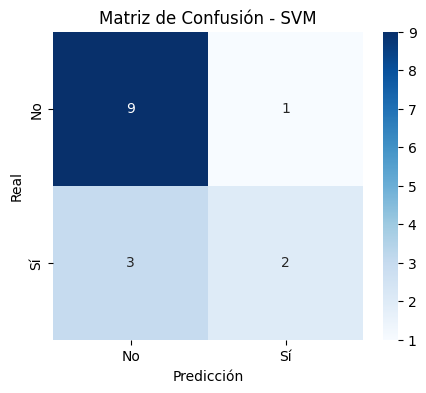

In [ ]:
# Importar librerías necesarias
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo SVM
def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    # Crear el modelo SVM con un kernel RBF
    svm = SVC(kernel='rbf', probability=True, random_state=42)

    # Entrenar el modelo
    svm.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - SVM")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate_svm(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate_svm(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate_svm(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate_svm(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


Holaaaa


Modelo: XGBoost
Accuracy: 0.6667
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        10
         1.0       0.50      0.60      0.55         5

    accuracy                           0.67        15
   macro avg       0.64      0.65      0.64        15
weighted avg       0.69      0.67      0.67        15

Matriz de Confusión para XGBoost:
 [[7 3]
 [2 3]]


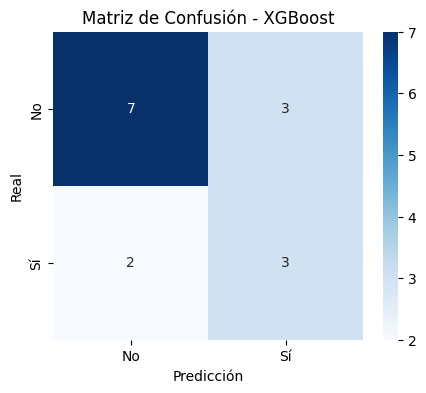

In [ ]:
# Importar librerías necesarias
from xgboost import XGBClassifier

# XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

# Evaluación de XGBoost
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Modelo: XGBoost")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"Matriz de Confusión para XGBoost:\n", cm_xgb)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()


Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 1.0000
🔹 Accuracy en test: 0.2667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.40      0.20      0.27        10
         1.0       0.20      0.40      0.27         5

    accuracy                           0.27        15
   macro avg       0.30      0.30      0.27        15
weighted avg       0.33      0.27      0.27        15



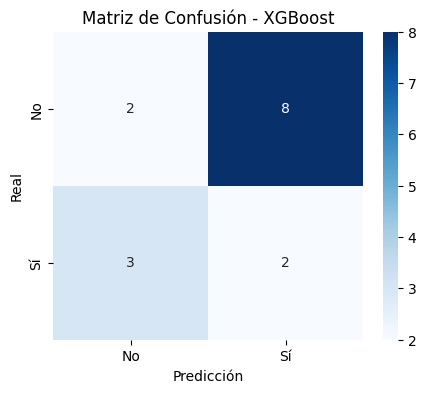

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 1.0000
🔹 Accuracy en test: 0.7333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.88      0.70      0.78        10
         1.0       0.57      0.80      0.67         5

    accuracy                           0.73        15
   macro avg       0.72      0.75      0.72        15
weighted avg       0.77      0.73      0.74        15



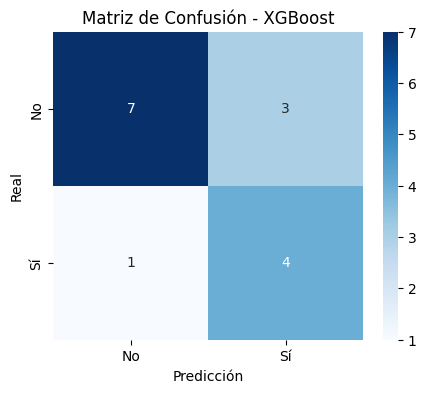

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 1.0000
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        10
         1.0       0.43      0.60      0.50         5

    accuracy                           0.60        15
   macro avg       0.59      0.60      0.58        15
weighted avg       0.64      0.60      0.61        15



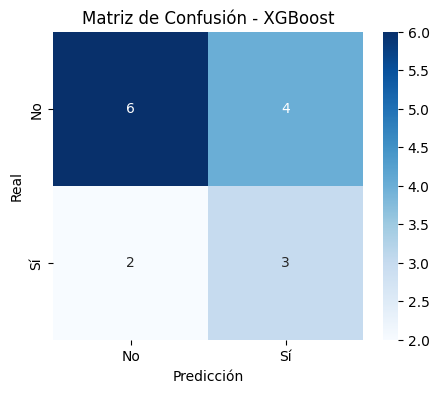

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 1.0000
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



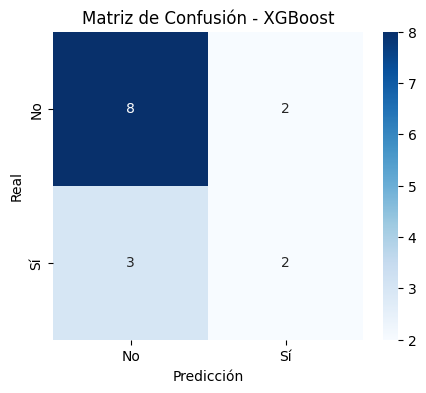

In [ ]:
# Importar librerías necesarias
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo
def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Crear el modelo XGBoost con los hiperparámetros dados
    xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

    # Entrenar el modelo
    xgb.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - XGBoost")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a optimizar para SVM
param_grid_svm = {
    'C': [0.1, 1, 10],  # Parámetro de regularización
    'kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'gamma': ['scale', 'auto']  # Parámetro de ajuste de la forma del kernel
}

# Usar GridSearchCV para encontrar los mejores parámetros
grid_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5)
grid_svm.fit(X_train_scaled, y_train)  # Usamos los datos escalados para SVM

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros para SVM:", grid_svm.best_params_)


Mejores parámetros para SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definir los parámetros a optimizar para XGBoost
param_grid_xgb = {
    'n_estimators': [10, 20, 50, 100],  # Número de árboles
    'max_depth': [3, 4, 5, 6],  # Profundidad máxima de los árboles
    'learning_rate': [0.01, 0.1, 0.2]  # Tasa de aprendizaje
}

# Usar GridSearchCV para encontrar los mejores parámetros
grid_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5)
grid_xgb.fit(X_train, y_train)  # Usamos los datos no escalados para XGBoost

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros para XGBoost:", grid_xgb.best_params_)


Mejores parámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50}


In [ ]:
# Random Forest
rf = RandomForestClassifier(max_depth = 5, n_estimators = 10, random_state=42)
rf.fit(X_train, y_train)
# SVM
svm = SVC(C =1, gamma= 'scale', kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
# XGBoost
xgb = XGBClassifier(n_estimators=300, max_depth = 6, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

Modelo: Random Forest
Accuracy: 0.6000
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15

Matriz de Confusión para Random Forest:
 [[7 3]
 [3 2]]


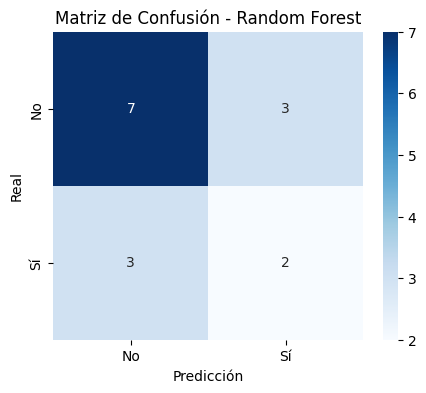

Modelo: SVM
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.33      0.40      0.36         5

    accuracy                           0.53        15
   macro avg       0.50      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15

Matriz de Confusión para SVM:
 [[6 4]
 [3 2]]


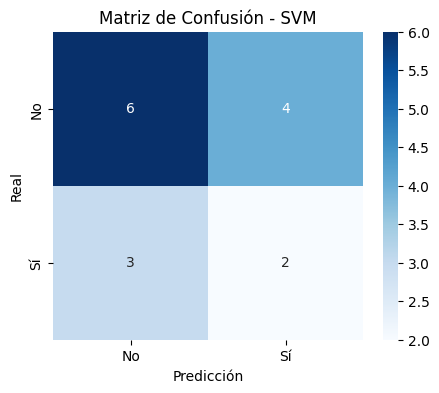

Modelo: XGBoost
Accuracy: 0.6667
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        10
         1.0       0.50      0.60      0.55         5

    accuracy                           0.67        15
   macro avg       0.64      0.65      0.64        15
weighted avg       0.69      0.67      0.67        15

Matriz de Confusión para XGBoost:
 [[7 3]
 [2 3]]


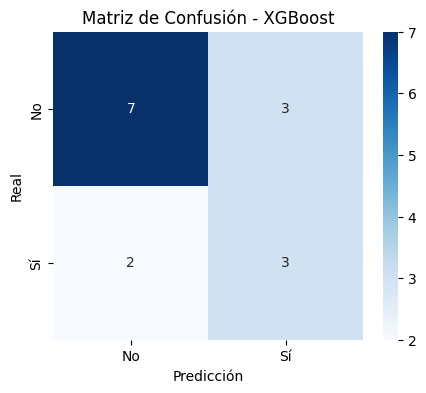

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluación de modelos ML
models = {'Random Forest': rf, 'SVM': svm, 'XGBoost': xgb}
for name, model in models.items():
    # Predicción de las clases
    y_pred = model.predict(X_test_scaled if name == 'SVM' else X_test)

    # Calcular y mostrar el accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Modelo: {name}")
    print(f"Accuracy: {accuracy:.4f}")

    # Imprimir el classification report
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

    # Calcular y mostrar la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    print(f"Matriz de Confusión para {name}:\n", cm)

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.5333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.67      0.60      0.63        10
         1.0       0.33      0.40      0.36         5

    accuracy                           0.53        15
   macro avg       0.50      0.50      0.50        15
weighted avg       0.56      0.53      0.54        15



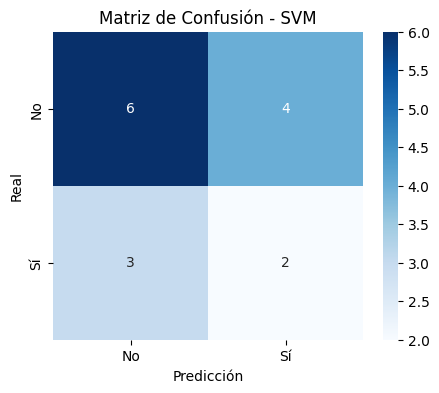

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



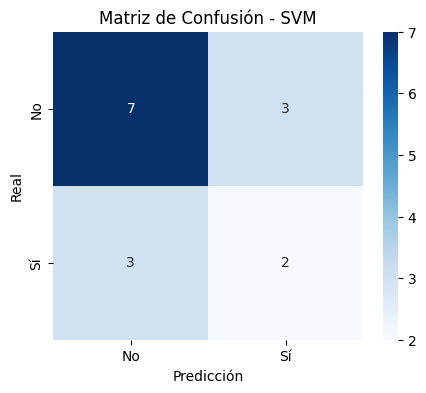

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 0.8281
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



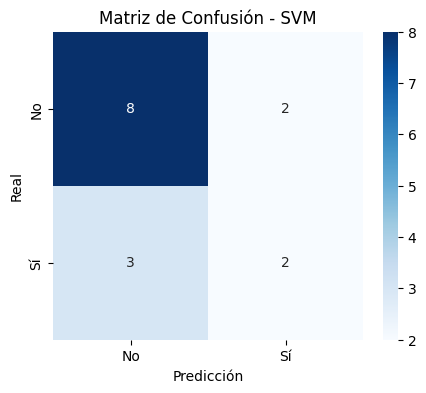

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 0.8136
🔹 Accuracy en test: 0.7333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.75      0.90      0.82        10
         1.0       0.67      0.40      0.50         5

    accuracy                           0.73        15
   macro avg       0.71      0.65      0.66        15
weighted avg       0.72      0.73      0.71        15



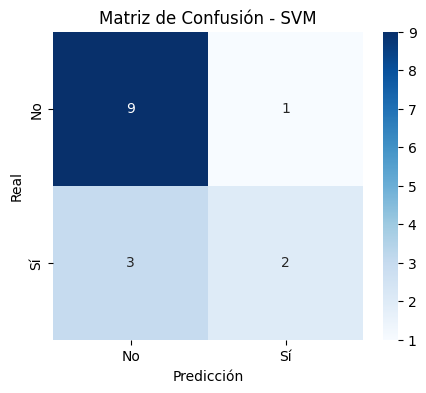

In [ ]:
# Importar librerías necesarias
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo SVM
def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    # Crear el modelo SVM con los hiperparámetros especificados
    svm = SVC(C=1, gamma='scale', kernel='rbf', probability=True, random_state=42)

    # Entrenar el modelo
    svm.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = svm.predict(X_train)
    y_pred_test = svm.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - SVM")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate_svm(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate_svm(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate_svm(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate_svm(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Rango de valores para búsqueda
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1.0, 1.5, 2.0],
}
xgb.fit(X_train, y_train)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Modelo: XGBoost
Accuracy: 0.5333
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.50      0.59        10
         1.0       0.38      0.60      0.46         5

    accuracy                           0.53        15
   macro avg       0.54      0.55      0.52        15
weighted avg       0.60      0.53      0.55        15

Matriz de Confusión para XGBoost:
 [[5 5]
 [2 3]]


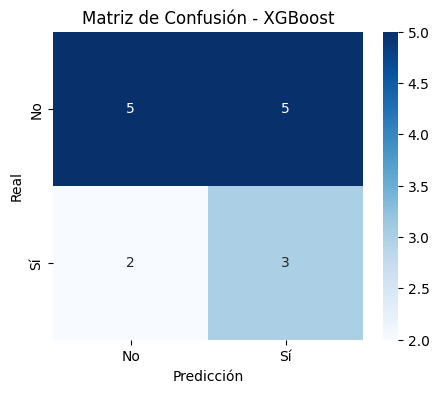

In [ ]:
# Evaluación solo para el modelo XGBoost
y_pred_xgb = xgb.predict(X_test)

# Calcular y mostrar el accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Modelo: XGBoost")
print(f"Accuracy: {accuracy:.4f}")

# Imprimir el classification report
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")

# Calcular y mostrar la matriz de confusión
cm = confusion_matrix(y_test, y_pred_xgb)
print(f"Matriz de Confusión para XGBoost:\n", cm)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

Modelo: XGBoost
Accuracy: 0.6000
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        10
         1.0       0.43      0.60      0.50         5

    accuracy                           0.60        15
   macro avg       0.59      0.60      0.58        15
weighted avg       0.64      0.60      0.61        15

Matriz de Confusión para XGBoost:
 [[6 4]
 [2 3]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:06:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


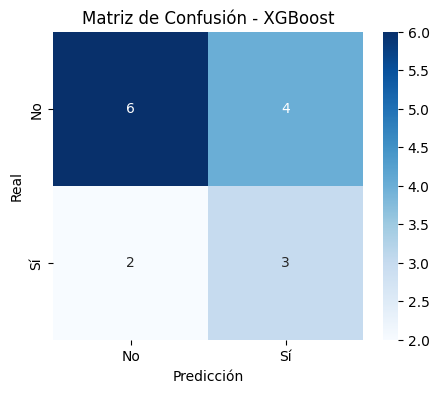

In [ ]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# XGBoost
xgb = XGBClassifier( n_estimators=10,
    learning_rate=0.1,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42)
xgb.fit(X_train, y_train)

# Evaluación de XGBoost
y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Modelo: XGBoost")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Classification Report:\n{classification_report(y_test, y_pred_xgb)}")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"Matriz de Confusión para XGBoost:\n", cm_xgb)

# Graficar la matriz de confusión
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - XGBoost")
plt.show()

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Modelo con configuración simple y conservadora
xgb = XGBClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=2,
    subsample=1.0,
    colsample_bytree=1.0,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Entrenamiento
xgb.fit(X_train, y_train)

# Predicción sobre el conjunto de test
y_pred = xgb.predict(X_test)

# Cálculo de accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo: {accuracy:.3f}")


Accuracy del modelo: 0.600


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:06:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# Definir early stopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Modelo 1: Red Neuronal Densa (MLP)
model_mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    # El dropout se usa para caso de overfitting para que la neurona no coja esa info o "no la vea" y no se ajuste el modelo tanto a los datos
    Dropout(0.2),
    # La activación de relu es por la estructura de clasificación y además en la operación en caso de que sea negativo de que el resultado sea negativo, los convierte a 0
    # Hablamos de la operación de activación
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
#Optimizadora Adam, hace uqe el peso de las neuronas se vaya modificando para disminuir el loss
#Optimizador con otro realmente no cambia mucho pero me decanto por el Adam que es el más usado
#Loss diferencia entre lo real y lo q ue el ha dicho
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Entrenar MLP
model_mlp.fit(X_train_scaled, y_train, epochs=50, batch_size=8, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4446 - loss: 0.7233 - val_accuracy: 0.6000 - val_loss: 0.6678
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5185 - loss: 0.6984 - val_accuracy: 0.6000 - val_loss: 0.6721
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5445 - loss: 0.6989 - val_accuracy: 0.5333 - val_loss: 0.6785
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5785 - loss: 0.6865 - val_accuracy: 0.4667 - val_loss: 0.6803
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7124 - loss: 0.6543 - val_accuracy: 0.4667 - val_loss: 0.6775
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7515 - loss: 0.6335 - val_accuracy: 0.5333 - val_loss: 0.6735
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7864 - loss: 0.6152 - val_accuracy: 0.4667 - val_loss: 0.6797
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8044 - loss: 0.6021 - val_accuracy: 0.4000 - val_loss: 0.6863


In [ ]:
# Modelo 2: Red Neuronal Profunda (DNN)
model_dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar DNN
model_dnn.fit(X_train_scaled, y_train, epochs=100, batch_size=8, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.4850 - loss: 0.7046 - val_accuracy: 0.6667 - val_loss: 0.6660
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5518 - loss: 0.6896 - val_accuracy: 0.6000 - val_loss: 0.6744
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7359 - loss: 0.6445 - val_accuracy: 0.6000 - val_loss: 0.6771
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8003 - loss: 0.6522 - val_accuracy: 0.5333 - val_loss: 0.6909
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6337 - loss: 0.6529 - val_accuracy: 0.4667 - val_loss: 0.6950
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7267 - loss: 0.6314 - val_accuracy: 0.5333 - val_loss: 0.7011
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7388 - loss: 0.6237 - val_accuracy: 0.4667 - val_loss: 0.6970
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7451 - loss: 0.6430 - val_accuracy: 0.5333 - val_loss: 0.6917
Epoc

In [ ]:
# Evaluación de modelos DL
mlp_loss, mlp_acc = model_mlp.evaluate(X_test_scaled, y_test)
dnn_loss, dnn_acc = model_dnn.evaluate(X_test_scaled, y_test)

print(f"MLP Accuracy: {mlp_acc:.4f}")
print(f"DNN Accuracy: {dnn_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6000 - loss: 0.6678
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6667 - loss: 0.6660
MLP Accuracy: 0.6000
DNN Accuracy: 0.6667


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
🔹 Modelo: Red Neuronal 1 (DL)
✅ Accuracy: 0.6000
✅ F1-Score: 0.5000

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       0.75      0.60      0.67        10
         1.0       0.43      0.60      0.50         5

    accuracy                           0.60        15
   macro avg       0.59      0.60      0.58        15
weighted avg       0.64      0.60      0.61        15



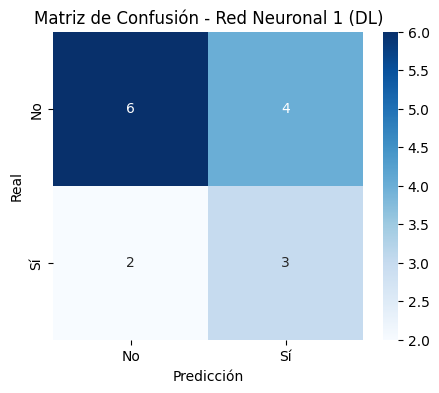

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
🔹 Modelo: Red Neuronal 2 (DL)
✅ Accuracy: 0.6667
✅ F1-Score: 0.4444

🔹 Clasificación detallada:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



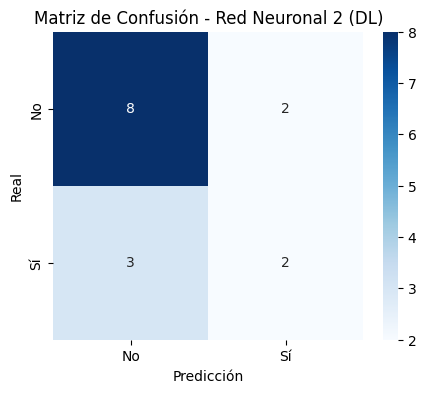

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# Función para evaluar modelos
def evaluar_modelo(nombre, modelo, X_test, y_test):
    # Obtener las predicciones
    if hasattr(modelo, 'predict_proba'):  # Modelos que devuelven probabilidades (e.g. RandomForest, SVM, XGBoost)
        y_pred_prob = modelo.predict_proba(X_test)[:, 1]  # Extraemos las probabilidades de la clase positiva
        y_pred = (y_pred_prob > 0.5).astype(int)  # Convertimos las probabilidades a clases binarias
    else:  # Modelos que devuelven clases directamente (e.g. MLP, DNN)
        y_pred = modelo.predict(X_test)
        if y_pred.ndim > 1:  # Si el modelo devuelve un array 2D, extraemos la clase
            y_pred = (y_pred[:, 0] > 0.5).astype(int)

    # Calcular las métricas de evaluación
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    matriz_conf = confusion_matrix(y_test, y_pred)

    # Mostrar resultados
    print(f"🔹 Modelo: {nombre}")
    print(f"✅ Accuracy: {acc:.4f}")
    print(f"✅ F1-Score: {f1:.4f}")
    print("\n🔹 Clasificación detallada:\n", classification_report(y_test, y_pred))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {nombre}")
    plt.show()

# Evaluar todos los modelos
modelos = {
    "Red Neuronal 1 (DL)": model_mlp,
    "Red Neuronal 2 (DL)": model_dnn,
}

# Evaluar cada modelo
for nombre, modelo in modelos.items():
    evaluar_modelo(nombre, modelo, X_test_scaled, y_test)


🔹 Accuracy en entrenamiento: 0.6949
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



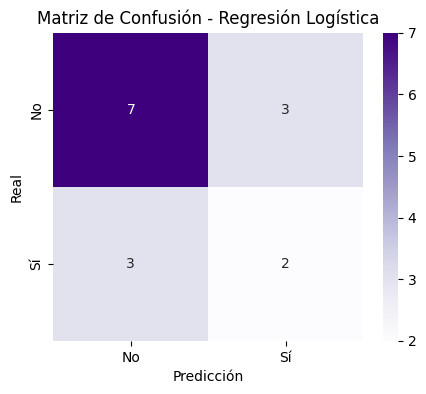

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Entrenar modelo de Regresión Logística
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train_scaled, y_train)

# 📌 Predicciones
y_pred_train = logreg.predict(X_train_scaled)
y_pred_test = logreg.predict(X_test_scaled)

# 📌 Accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
print(f"🔹 Accuracy en test: {acc_test:.4f}")

# 📌 Reporte de clasificación (solo en test)
print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

# 📌 Matriz de confusión
matriz_conf = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Purples", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()



Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 0.6610
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.78      0.70      0.74        10
         1.0       0.50      0.60      0.55         5

    accuracy                           0.67        15
   macro avg       0.64      0.65      0.64        15
weighted avg       0.69      0.67      0.67        15



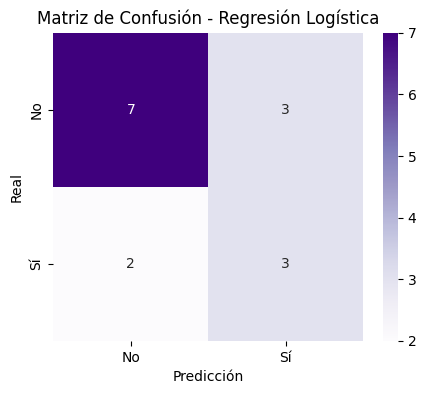

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 0.7119
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.70      0.70      0.70        10
         1.0       0.40      0.40      0.40         5

    accuracy                           0.60        15
   macro avg       0.55      0.55      0.55        15
weighted avg       0.60      0.60      0.60        15



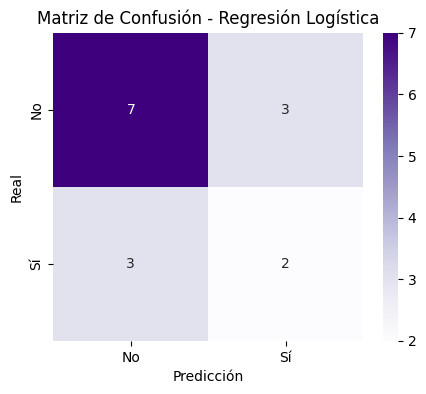

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 0.7188
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



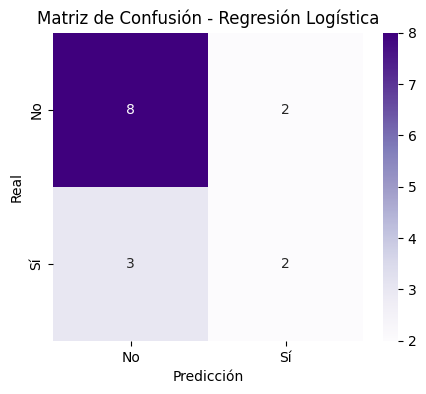

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 0.7119
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.73      0.80      0.76        10
         1.0       0.50      0.40      0.44         5

    accuracy                           0.67        15
   macro avg       0.61      0.60      0.60        15
weighted avg       0.65      0.67      0.66        15



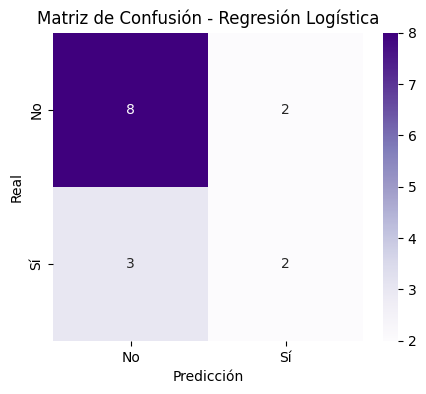

In [ ]:
# Importar librerías necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo de Regresión Logística
def train_and_evaluate_logreg(X_train, X_test, y_train, y_test):
    # Crear el modelo de Regresión Logística
    logreg = LogisticRegression(random_state=42, max_iter=1000)

    # Entrenar el modelo
    logreg.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = logreg.predict(X_train)
    y_pred_test = logreg.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Purples", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Regresión Logística")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate_logreg(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate_logreg(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate_logreg(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate_logreg(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


🔹 Accuracy en entrenamiento: 0.6610
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.64      0.90      0.75        10
         1.0       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.32      0.45      0.38        15
weighted avg       0.43      0.60      0.50        15



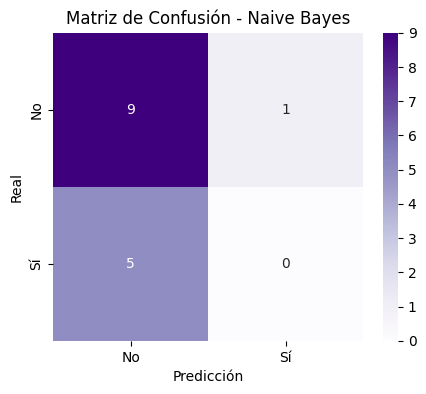

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 📌 Entrenar modelo de Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# 📌 Predicciones
y_pred_train = nb.predict(X_train_scaled)
y_pred_test = nb.predict(X_test_scaled)

# 📌 Accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
print(f"🔹 Accuracy en test: {acc_test:.4f}")

# 📌 Reporte de clasificación (solo en test)
print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

# 📌 Matriz de confusión
matriz_conf = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 4))
sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Purples", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Naive Bayes")
plt.show()


Evaluación con datos aumentados por ruido aleatorio:
🔹 Accuracy en entrenamiento: 0.6441
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.67      1.00      0.80        10
         1.0       0.00      0.00      0.00         5

    accuracy                           0.67        15
   macro avg       0.33      0.50      0.40        15
weighted avg       0.44      0.67      0.53        15



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


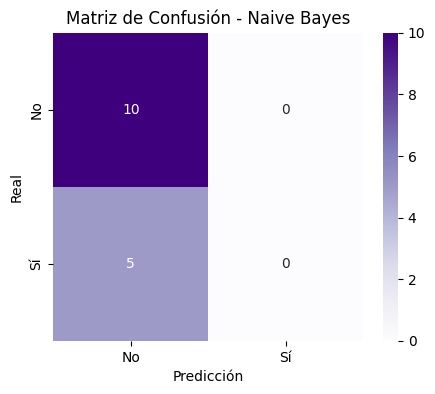

Evaluación con datos aumentados por escalado:
🔹 Accuracy en entrenamiento: 0.6610
🔹 Accuracy en test: 0.6000

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.64      0.90      0.75        10
         1.0       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.32      0.45      0.38        15
weighted avg       0.43      0.60      0.50        15



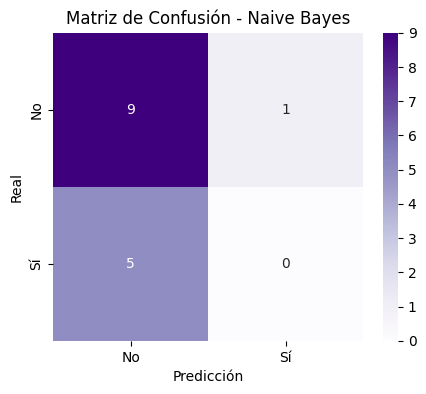

Evaluación con datos aumentados por SMOTE:
🔹 Accuracy en entrenamiento: 0.6719
🔹 Accuracy en test: 0.6667

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.69      0.90      0.78        10
         1.0       0.50      0.20      0.29         5

    accuracy                           0.67        15
   macro avg       0.60      0.55      0.53        15
weighted avg       0.63      0.67      0.62        15



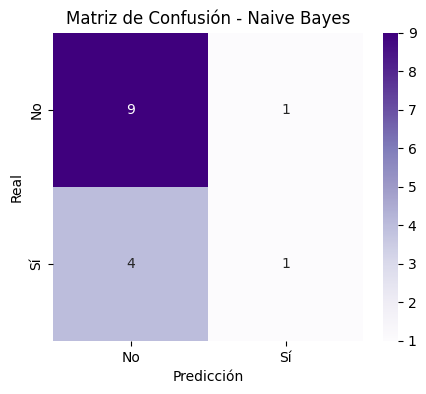

Evaluación con datos aumentados por Bootstrap:
🔹 Accuracy en entrenamiento: 0.6610
🔹 Accuracy en test: 0.7333

🔹 Reporte de clasificación en test:
               precision    recall  f1-score   support

         0.0       0.71      1.00      0.83        10
         1.0       1.00      0.20      0.33         5

    accuracy                           0.73        15
   macro avg       0.86      0.60      0.58        15
weighted avg       0.81      0.73      0.67        15



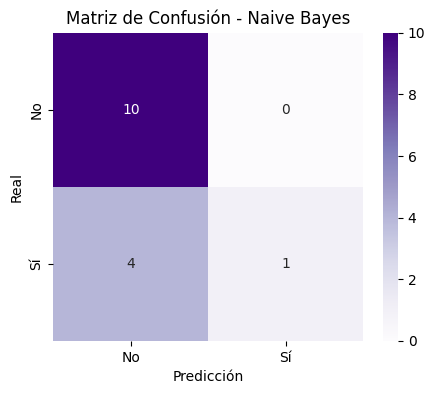

In [ ]:
# Importar librerías necesarias
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (solo para modelos que lo necesitan)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Función para entrenar y evaluar el modelo de Naive Bayes
def train_and_evaluate_nb(X_train, X_test, y_train, y_test):
    # Crear el modelo de Naive Bayes
    nb = GaussianNB(var_smoothing =1e-06)

    # Entrenar el modelo
    nb.fit(X_train, y_train)

    # Hacer predicciones
    y_pred_train = nb.predict(X_train)
    y_pred_test = nb.predict(X_test)

    # Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    # Matriz de confusión
    matriz_conf = confusion_matrix(y_test, y_pred_test)

    # Mostrar resultados
    print(f"🔹 Accuracy en entrenamiento: {acc_train:.4f}")
    print(f"🔹 Accuracy en test: {acc_test:.4f}")

    # Reporte de clasificación
    print("\n🔹 Reporte de clasificación en test:\n", classification_report(y_test, y_pred_test))

    # Graficar la matriz de confusión
    plt.figure(figsize=(5, 4))
    sns.heatmap(matriz_conf, annot=True, fmt="d", cmap="Purples", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión - Naive Bayes")
    plt.show()

# 1. **Perturbación Aleatoria (Random Noise)**
# Agregar ruido aleatorio a las características de entrenamiento
noise = np.random.normal(0, 0.1, X_train_scaled.shape)  # Ruido con media 0 y desviación estándar 0.1
X_train_augmented_noise = X_train_scaled + noise
print("Evaluación con datos aumentados por ruido aleatorio:")
train_and_evaluate_nb(X_train_augmented_noise, X_test_scaled, y_train, y_test)

# 2. **Escalado (Scaling)**
# Aplicar un factor de escala aleatorio entre 0.9 y 1.1 a las características de entrenamiento
scaling_factors = np.random.uniform(0.9, 1.1, X_train_scaled.shape[1])  # Factores de escala aleatorios
X_train_augmented_scaled = X_train_scaled * scaling_factors
print("Evaluación con datos aumentados por escalado:")
train_and_evaluate_nb(X_train_augmented_scaled, X_test_scaled, y_train, y_test)

# 3. **SMOTE (Synthetic Minority Over-sampling Technique)**
# Aumentar los datos de la clase minoritaria con SMOTE
smote = SMOTE(random_state=42)
X_train_augmented_smote, y_train_augmented_smote = smote.fit_resample(X_train_scaled, y_train)
print("Evaluación con datos aumentados por SMOTE:")
train_and_evaluate_nb(X_train_augmented_smote, X_test_scaled, y_train_augmented_smote, y_test)

# 4. **Bootstrap Resampling**
# Realizar re-muestreo con reemplazo de las muestras de entrenamiento (Bootstrap)
X_train_augmented_bootstrap, y_train_augmented_bootstrap = resample(X_train_scaled, y_train, random_state=42)
print("Evaluación con datos aumentados por Bootstrap:")
train_and_evaluate_nb(X_train_augmented_bootstrap, X_test_scaled, y_train_augmented_bootstrap, y_test)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores hiperparámetros encontrados: {'var_smoothing': 1e-06}
Accuracy en el conjunto de test: 0.6000

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.64      0.90      0.75        10
         1.0       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.32      0.45      0.38        15
weighted avg       0.43      0.60      0.50        15



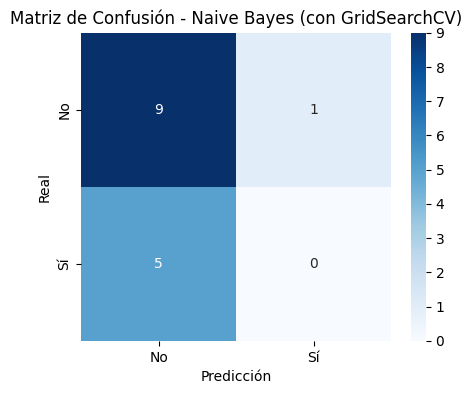

In [ ]:
# Importar librerías necesarias
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Definir características (X) y variable objetivo (y)
X = data_modelo2.drop(columns=['degenera'])  # Eliminar la columna objetivo
y = data_modelo2['degenera']  # Variable objetivo

# Dividir en entrenamiento (80%) y prueba (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar el clasificador de Naive Bayes
nb = GaussianNB()

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Este es el único hiperparámetro que se puede ajustar en GaussianNB
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Entrenar el modelo con GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:", grid_search.best_params_)

# Mejor modelo
best_nb = grid_search.best_estimator_

# Evaluación del mejor modelo en el conjunto de test
y_pred = best_nb.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy en el conjunto de test: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Sí"], yticklabels=["No", "Sí"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Naive Bayes (con GridSearchCV)")
plt.show()


In [ ]:
import joblib

# Guardar el modelo Random Forest con joblib
joblib.dump(rf, 'modelo_random_forest.pkl')

# Para cargar el modelo en otra parte
rf_cargado = joblib.load('modelo_random_forest.pkl')


In [ ]:
# Guardar el modelo en un archivo .joblib
joblib.dump(rf, 'modelo_random_forest.joblib')

# Para cargar el modelo más tarde
rf_cargado = joblib.load('modelo_random_forest.joblib')

In [ ]:
# Guardar el modelo de XGBoost en formato joblib
joblib.dump(xgb, 'modelo_xgboost.joblib')

# Para cargar el modelo más tarde
xgb_cargado = joblib.load('modelo_xgboost.joblib')